In [105]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dota2data/dota2Test.csv
/kaggle/input/dota2data/dota2Train.csv


First thing i realized is that the dataset does not have column names. So I had to manually add this in.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92650 entries, 0 to 92649
Columns: 117 entries, win to 113
dtypes: int64(117)
memory usage: 82.7 MB
None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10294 entries, 0 to 10293
Columns: 117 entries, win to 113
dtypes: int64(117)
memory usage: 9.2 MB
None
   win  clusterid  gamemode  gametype  1  2  3  4  5  6  ...  104  105  106  \
0   -1        223         2         2  0  0  0  0  0  0  ...    0    0    0   
1    1        152         2         2  0  0  0  1  0 -1  ...    0    0    0   
2    1        131         2         2  0  0  0  1  0 -1  ...    0    0    0   
3    1        154         2         2  0  0  0  0  0  0  ...   -1    0    0   
4   -1        171         2         3  0  0  0  0  0 -1  ...    0    0    0   

   107  108  109  110  111  112  113  
0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0  
4    0    0    0  

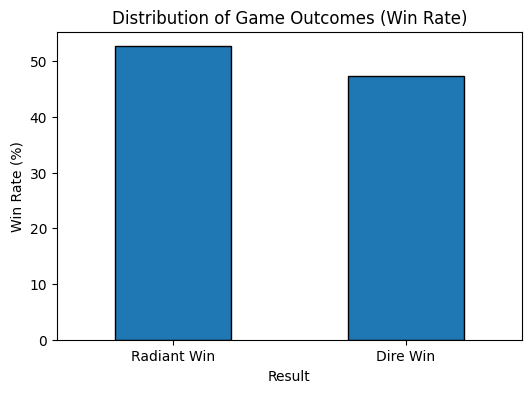

Win Rates (in percentages):
win
Radiant Win    52.651916
Dire Win       47.348084
Name: proportion, dtype: float64


In [106]:
train = pd.read_csv("/kaggle/input/dota2data/dota2Train.csv", header=None)
test = pd.read_csv("/kaggle/input/dota2data/dota2Test.csv", header=None)

first_columns = ['win', 'clusterid', 'gamemode', 'gametype']

hero_columns = [str(i) for i in range(1, train.shape[1] - 4 + 1)]

all_columns = first_columns + hero_columns

train.columns = all_columns
test.columns = all_columns

print(train.info())
print('\n\n')
print(test.info())


print(train.head())
print(train.iloc[0])
print('\n\n')
print(test.head())


print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print('\n\n')


labels = train['win'].map({1: 'Radiant Win', -1: 'Dire Win'})


win_counts = labels.value_counts(normalize=True) * 100


plt.figure(figsize=(6,4))
win_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Result')
plt.ylabel('Win Rate (%)')
plt.title('Distribution of Game Outcomes (Win Rate)')
plt.xticks(rotation=0)
plt.show()


print("Win Rates (in percentages):")
print(win_counts)


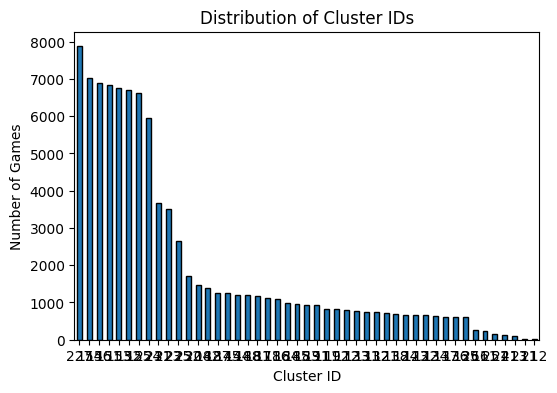

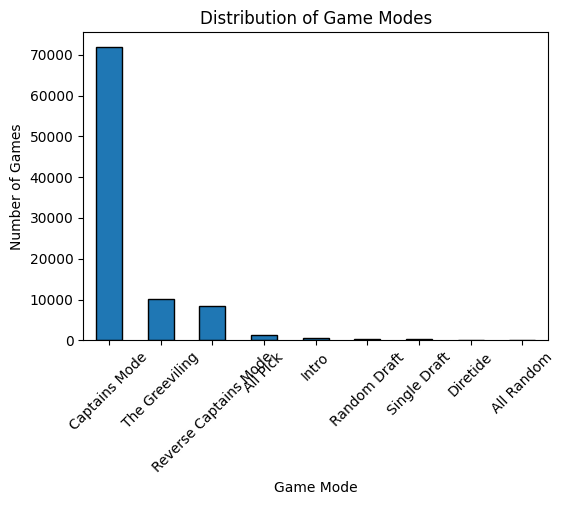

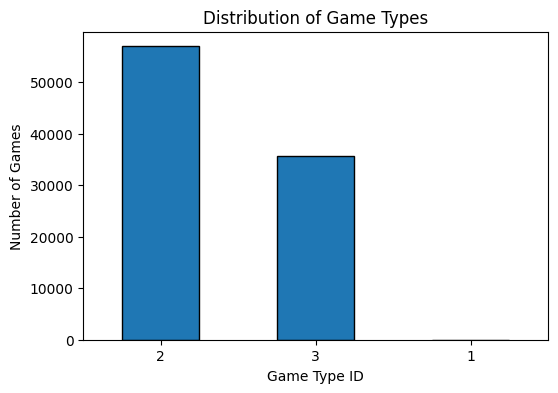

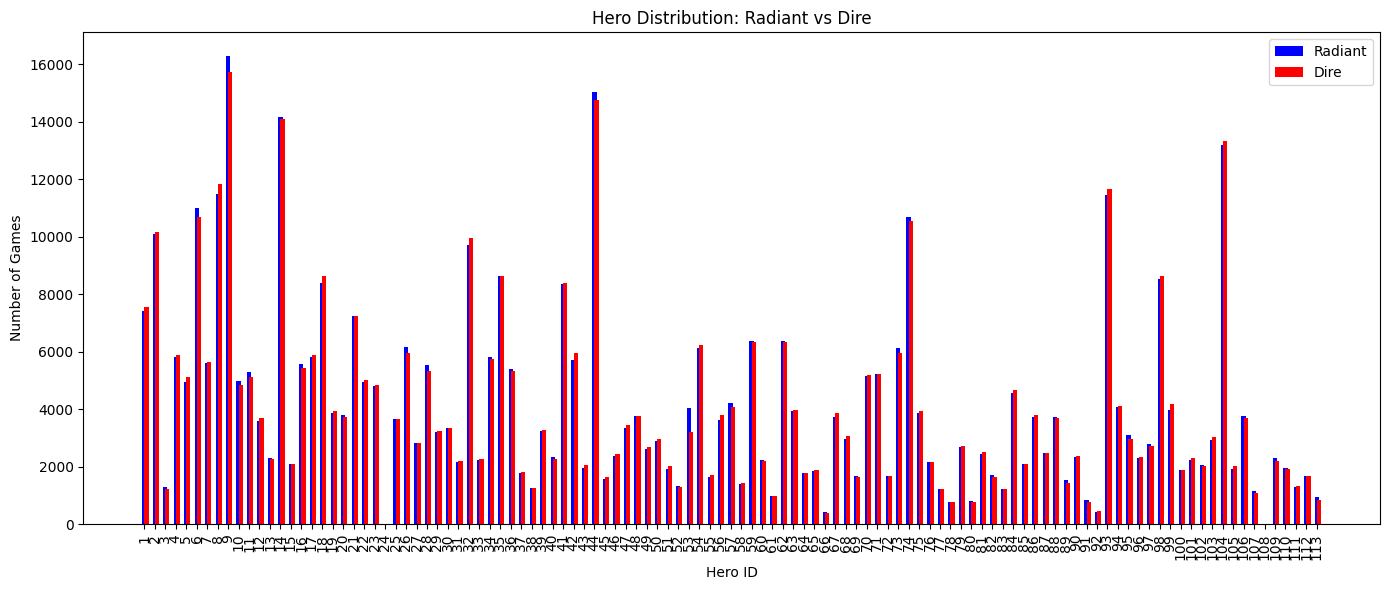

Radiant Hero Counts:
1       7411
2      10087
3       1294
4       5814
5       4932
       ...  
109     2304
110     1961
111     1308
112     1668
113      937
Length: 113, dtype: int64

Dire Hero Counts:
1       7562
2      10177
3       1230
4       5888
5       5118
       ...  
109     2209
110     1901
111     1329
112     1672
113      854
Length: 113, dtype: int64


In [107]:
import matplotlib.pyplot as plt


gamemode_map = {
    1: 'All Pick',
    2: 'Captains Mode',
    3: 'Random Draft',
    4: 'Single Draft',
    5: 'All Random',
    6: 'Intro',
    7: 'Diretide',
    8: 'Reverse Captains Mode',
    9: 'The Greeviling',
    

}



gamemode_labels = train['gamemode'].map(gamemode_map)


plt.figure(figsize=(6, 4))
train['clusterid'].value_counts().plot(kind='bar', edgecolor='black')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Games')
plt.title('Distribution of Cluster IDs')
plt.xticks(rotation=0)
plt.show()


plt.figure(figsize=(6, 4))
gamemode_labels.value_counts().plot(kind='bar', edgecolor='black')
plt.xlabel('Game Mode')
plt.ylabel('Number of Games')
plt.title('Distribution of Game Modes')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(6, 4))
train['gametype'].value_counts().plot(kind='bar', edgecolor='black')
plt.xlabel('Game Type ID')
plt.ylabel('Number of Games')
plt.title('Distribution of Game Types')
plt.xticks(rotation=0)
plt.show()




hero_columns = [str(i) for i in range(1, 114)]


heroes_radiant = train[hero_columns].apply(lambda x: x == 1).sum(axis=0) 
heroes_dire = train[hero_columns].apply(lambda x: x == -1).sum(axis=0) 


fig, ax = plt.subplots(figsize=(14, 6))


ax.bar(heroes_radiant.index, heroes_radiant, width=0.4, label='Radiant', align='center', color='b')
ax.bar(heroes_dire.index, heroes_dire, width=0.4, label='Dire', align='edge', color='r')

ax.set_xlabel('Hero ID')
ax.set_ylabel('Number of Games')
ax.set_title('Hero Distribution: Radiant vs Dire')
ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


print("Radiant Hero Counts:")
print(heroes_radiant)
print("\nDire Hero Counts:")
print(heroes_dire)

train = train[~train['gamemode'].isin([3, 4, 6])]
train = train.reset_index(drop=True)

#try and drop clusterID and see what diff it makes if any

### Looking at the data, cluser id could be important since different regions could be better with different heroes, i'll be trying it with and without.
### The distribution of game modes in this data set is heavily skewed towards a single type 'Captains Mode' where teams generally take the game more seriously.
#### I should remove 'for fun' modes like The greeviling/diretide/reverse captains mode to clean the data from modes where people generally don't try as hard to win. My issue is that the dataset im using doesn't have a mapping of game-modes to id's so I have to refer to other documentation, and I'm not sure if that other documentation is correct. https://demodota2api.readthedocs.io/_/downloads/en/latest/pdf/ and https://github.com/odota/dotaconstants/blob/e2d4d47b91e52690a3e8da246fb3a0cddba2bde7/json/game_mode.json are both resources that I referenced, but I'm not very confident on them being correct. I'll try models with and without the removal of the 'for fun' modes and see what happens

#### Next I think I'll be dropping the game type column(ranked, unranked, bot games) as I think it'll just add noise. Filtering on game mode should be enough to remove 'for fun' games

#### Another thing to remove is the empty hero ids 24 and 108 since they are not actually pickable characters.

In [108]:
train = train.drop(columns=['clusterid','gametype', '24', '108'])
test = test.drop(columns=['clusterid','gametype', '24', '108'])

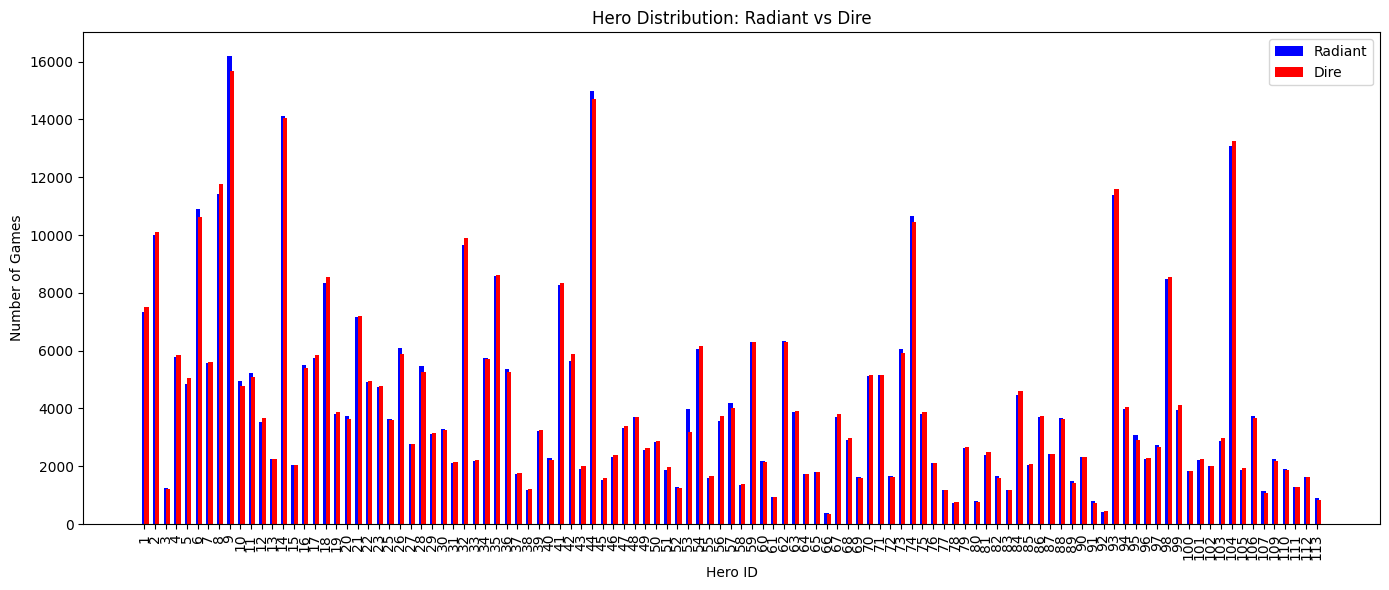

In [109]:

hero_columns = [str(i) for i in range(1, 114) if i not in [24, 108]]


heroes_radiant = train[hero_columns].apply(lambda x: x == 1).sum(axis=0) 
heroes_dire = train[hero_columns].apply(lambda x: x == -1).sum(axis=0)

fig, ax = plt.subplots(figsize=(14, 6))


ax.bar(heroes_radiant.index, heroes_radiant, width=0.4, label='Radiant', align='center', color='b')
ax.bar(heroes_dire.index, heroes_dire, width=0.4, label='Dire', align='edge', color='r')

ax.set_xlabel('Hero ID')
ax.set_ylabel('Number of Games')
ax.set_title('Hero Distribution: Radiant vs Dire')
ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

As this is a game with balanced matchmaking, I don't really see any purpose in finding correlations with winrate and characters. What I really want to achive with this model is to be able to more acuratly predict the winner of a match when looking at what heroes are on each team. 

## Random Guess = 50% Accuracy
## Guessing Radiant every time = ~52.5% Accuracy
## Have to get higher than ~55% to prove any worth

In [110]:
all_columns = train.columns

features = [col for col in train.columns if col != 'win']

y = train['win']
X = train[features]

X_test = test[features]
y_test = test['win']

In [111]:
model = LogisticRegression(solver='liblinear', max_iter=10000)
model.fit(X, y)
y_pred = model.predict(X_test)


In [112]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
logistic_acc = accuracy

Accuracy: 0.5966


In [113]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
knn_acc = accuracy

In [114]:
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 53.23%
Confusion Matrix:
[[2350 2442]
 [2373 3129]]


In [115]:
from sklearn.tree import DecisionTreeClassifier
max_depth = 10
max_leaf_nodes = 10
dtc = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=42)
dtc.fit(X, y)
y_pred = dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5513


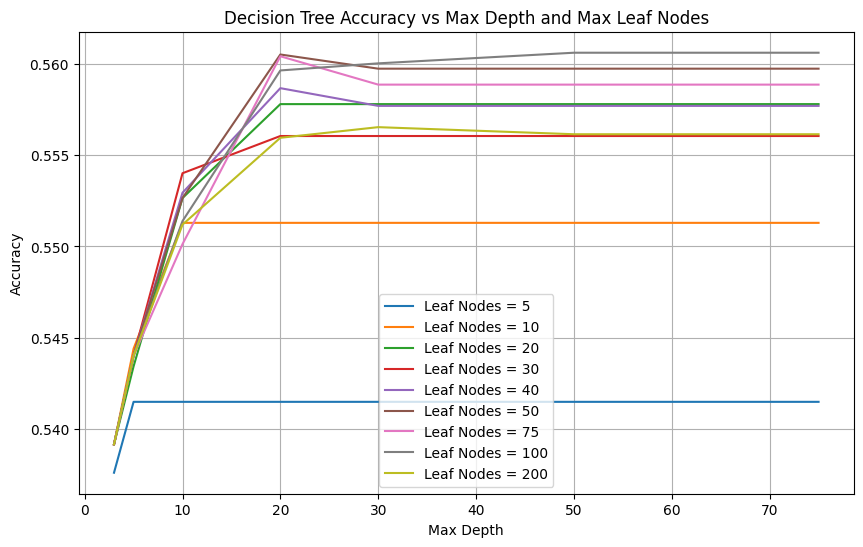

    max_depth  max_leaf_nodes  accuracy
0           3               5  0.537595
1           3              10  0.539149
2           3              20  0.539149
3           3              30  0.539149
4           3              40  0.539149
..        ...             ...       ...
58         75              40  0.557704
59         75              50  0.559744
60         75              75  0.558869
61         75             100  0.560618
62         75             200  0.556149

[63 rows x 3 columns]


In [116]:
# Define ranges for max_depth and max_leaf_nodes
depth_values = [3, 5, 10, 20, 30, 50,75]
leaf_values = [5, 10, 20, 30, 40, 50,75,100,200]


results = []


for max_depth in depth_values:
    for max_leaf_nodes in leaf_values:
        dtc = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=42)
        dtc.fit(X, y)


        y_pred = dtc.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)


        results.append({
            'max_depth': max_depth,
            'max_leaf_nodes': max_leaf_nodes,
            'accuracy': accuracy
        })

results_df = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
for max_leaf_nodes in leaf_values:
    subset = results_df[results_df['max_leaf_nodes'] == max_leaf_nodes]
    plt.plot(subset['max_depth'], subset['accuracy'], label=f"Leaf Nodes = {max_leaf_nodes}")

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth and Max Leaf Nodes')
plt.legend()
plt.grid(True)
plt.show()


print(results_df)

In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, 20, 30, 50,75],
    'max_leaf_nodes': [5, 10, 20, 30, 40, 50,75,100,200]
}


dtc = DecisionTreeClassifier(random_state=42)


grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')


grid_search.fit(X, y)


print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")
tree_acc = test_accuracy

Best Parameters: {'max_depth': 20, 'max_leaf_nodes': 100}
Best Cross-validation Score: 0.5576028247111178
Test Set Accuracy: 0.5596


In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=30,       
    random_state=42
)


rf.fit(X, y)




RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42)

In [119]:

y_pred = rf.predict(X_test)

forest_acc = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5871381387215854

Classification Report:
               precision    recall  f1-score   support

          -1       0.58      0.43      0.49      4792
           1       0.59      0.72      0.65      5502

    accuracy                           0.59     10294
   macro avg       0.58      0.58      0.57     10294
weighted avg       0.59      0.59      0.58     10294


Confusion Matrix:
 [[2068 2724]
 [1526 3976]]


Found good values at 200 trees and max depth of 30

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

highest_acc = 0
best_params = {}

def try_gbc(n_estimators=100, learning_rate=0.1, max_depth=3):
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )
    model.fit(X, y)
    

    y_pred = model.predict(X_test)
    

    acc = accuracy_score(y_test, y_pred)
    print(f"n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth} --> Accuracy: {acc:.4f}")
    return acc



configs = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5},
    {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 6},
]


for config in configs:
    acc = try_gbc(config['n_estimators'], config['learning_rate'], config['max_depth'])
    

    if acc > highest_acc:
        highest_acc = acc
        best_params = config


print(f"Best Accuracy: {highest_acc:.4f}")
print(f"Best Parameters: {best_params}")
gradient_acc = highest_acc

n_estimators=100, learning_rate=0.1, max_depth=3 --> Accuracy: 0.5811
n_estimators=200, learning_rate=0.05, max_depth=5 --> Accuracy: 0.5897
n_estimators=300, learning_rate=0.01, max_depth=6 --> Accuracy: 0.5791
Best Accuracy: 0.5897
Best Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5}


In [121]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pandas as pd


max_iter_options = [200, 250, 350]
learning_rate_options = [0.05, 0.1, 0.2]
max_depth_options = [3, 5, 7, 9]


results = []


for max_iter in max_iter_options:
    for learning_rate in learning_rate_options:
        for max_depth in max_depth_options:
            # Create and train model
            model = HistGradientBoostingClassifier(
                max_iter=max_iter,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            model.fit(X, y)
            

            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            

            results.append({
                'max_iter': max_iter,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'accuracy': acc
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='accuracy', ascending=False)
best_result = results_df.iloc[0]
print(results_df)


    max_iter  learning_rate  max_depth  accuracy
26       350           0.05          7  0.596950
17       250           0.10          5  0.596464
29       350           0.10          5  0.596464
25       350           0.05          5  0.596464
27       350           0.05          9  0.595590
5        200           0.10          5  0.595590
21       250           0.20          5  0.595201
9        200           0.20          5  0.595201
33       350           0.20          5  0.595201
31       350           0.10          9  0.595007
19       250           0.10          9  0.595007
7        200           0.10          9  0.595007
14       250           0.05          7  0.595007
10       200           0.20          7  0.594813
22       250           0.20          7  0.594813
34       350           0.20          7  0.594813
28       350           0.10          3  0.594521
13       250           0.05          5  0.594230
23       250           0.20          9  0.593841
35       350        

In [122]:
logistic_acc
knn_acc
tree_acc
forest_acc
gradient_acc
best_result['accuracy']

print('logistic acc:', logistic_acc)
print('knn acc:', knn_acc)
print('tree acc:', tree_acc)
print('forest acc:', forest_acc)
print('gradient acc:', gradient_acc)
print('hist gradient acc:', best_result['accuracy'])


logistic acc: 0.5965611035554692
knn acc: 0.5322517971633961
tree acc: 0.5596463959588109
forest acc: 0.5871381387215854
gradient acc: 0.5896638818729357
hist gradient acc: 0.5969496794249077



|Method|Accuracy|
|:----|:--------:|
|Logistic Regression|.596 |
|KNN|.532|
|Tree| .559|
|Random Forest| .587|
|Gradient Boosting| .589 |
|HistGradient Boosting|.596  |



# Logistic Regression & Hist Gradient Boosting did great

#### Tree and KNN understandably did poorly 

# Overall got a 59.6% accuracy which seems good?


## [Github Link](https://github.com/aSopha/Dota2-Supervised-Win-Predictor)